<a href="https://colab.research.google.com/github/R-Mahmoudi/Visualize-In_CNN/blob/main/Visualize_In_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/R-Mahmoudi/Visualize-In_CNN.git


Cloning into 'Visualize-In_CNN'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 90 (delta 1), reused 3 (delta 1), pack-reused 85
Unpacking objects: 100% (90/90), 49.17 MiB | 12.00 MiB/s, done.


In [7]:
cd /content/Visualize-In_CNN/

/content/Visualize-In_CNN


GridspecLayout(children=(FileUpload(value={'125.jpg': {'metadata': {'name': '125.jpg', 'type': 'image/jpeg', '…

1/1 [==============================] - 0s 457ms/step
Feature map shape: (1, 224, 224, 64). Visualize maximum 64 feature maps.


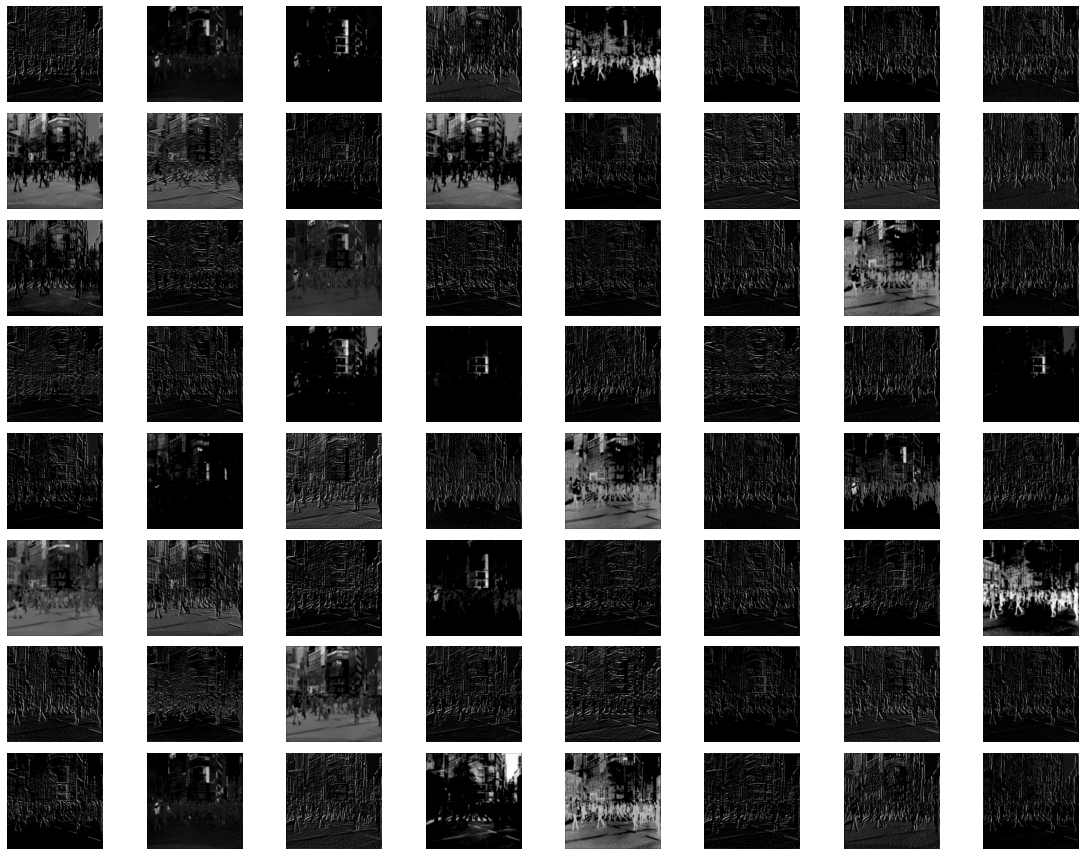

In [8]:
import tensorflow as tf
import io
from PIL import Image
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras import backend as K

import ipywidgets as widgets
from IPython.display import display, Javascript, HTML, clear_output, IFrame
from ipywidgets import interact, interactive, fixed, interact_manual, AppLayout, GridspecLayout
import matplotlib.pyplot as plt

from src.utils import model_dicts, array2bytes, create_model, get_conv_layers
from src.guidedBacprop import GuidedBackprop, deprocess_image
from src.gradcam import GradCAM, overlay_gradCAM
from src.filtersVis import extract_filter, vis_filter
from src.featuresVis import FeaturesExtraction, vis_feature_map
from src.deepdream import preprocess_deep_dream, deprocess_deep_dream, DeepDream

def create_expanded_button(description, button_style):
    return widgets.Button(description=description, button_style=button_style,
                          layout=widgets.Layout(height='auto', width='auto'))

model_ls = ["--Select"] + list(model_dicts.keys())
layer_ls = ["--Select"]
method_ls = ["--Select","Filter vis", "Feature map vis","Guided Backprop"]
class_ls = ["--Select"]

uploader = widgets.FileUpload()
show_but = create_expanded_button("Show image","success")
header = widgets.HTML('<font color="#1f77b4" face="sans-serif"><center><h1>Visualize and Explain Networks</h1><h3>All pre-trained models (Keras) on ImageNet</h3><hr style="height:2px;border-width:0;color:gray;background-color:gray"></center></font>',
                      layout=widgets.Layout(height='auto'))
models = widgets.Dropdown(options=model_ls, description="Model: ", layout={"width":"auto"},disabled=False)
layers = widgets.Dropdown(options=layer_ls, description="Layer: ", layout={"width":"auto"},disabled=False)
vis_but = create_expanded_button("Visualize","info")
methods = widgets.Dropdown(options=method_ls, description="Vis method: ", layout={"width":"auto"},disabled=False)
explain_but = create_expanded_button("Predict & Explain","warning")
classes = widgets.Dropdown(options=class_ls, description="Vis class: ", layout={"width":"auto"},disabled=False)
visclass_but = create_expanded_button("Vis this class","danger")
deep_dream_but = create_expanded_button("Generate","primary")
deco = widgets.Image(
    value=open("images/lapan.jpg","rb").read(),
    format="jpg",
    width="auto",
    height="auto",
    align="center-align"
)

# Layout
grid = GridspecLayout(15,30,height="600px")
grid[0,:4] = uploader
grid[0,5:9] = show_but
grid[0:3,10:] = header
grid[2,:9] = models
grid[3,:9] = widgets.HTML('<hr style="height:2px;border-width:0;color:gray;background-color:gray"><font color="gray" face="sans-serif"><center><h4>Filter and Feature Map Vis</h4></center>')
grid[4,:9] = layers
grid[5,:9] = methods
grid[7,:9] = vis_but
grid[8,:9] = widgets.HTML('<hr style="height:2px;border-width:0;color:gray;background-color:gray"><font color="gray" face="sans-serif"><center><h4>Explanation</h4></center>')
grid[9,:9] = explain_but
grid[11,:9] = classes
grid[13,:9] = widgets.HTML('<hr style="height:2px;border-width:0;color:gray;background-color:gray"><font color="gray" face="sans-serif"><center><h4>Deep Dream</h4></center>')
grid[14,:9] = deep_dream_but
grid[4:12,10:] = deco
grid[14,10:] = widgets.HTML('<font color="gray" face="sans-serif"><center><h4>Lang Co, Hue, Vietnam</h4></center>')
display(grid)

def on_change_model(change):
    if change["type"] == "change" and change["name"] == "value":
        chosen_model = change["new"]
        if chosen_model == "--Select":
            layer_ls = ["--Select"]
        else:
            model = create_model(chosen_model)
            layers.options = get_conv_layers(model)
        K.clear_session()
        
    
def show_button(sender):
    image = None
    for _, file_info in uploader.value.items():
        image = Image.open(io.BytesIO(file_info['content']))
    assert image is not None, "Please upload an image."   
    img = np.array(image)
    image.close()
    uploaded_img = widgets.Image(value=array2bytes(img))
    grid[4:10,10:] = uploaded_img
    grid[14,10:] = widgets.HTML('')
    
def vis_button(sender):
    clear_output()
    display(grid)
    model_name = models.value
    assert model_name != "--Select", "Please select a model to work on."
    model = create_model(model_name)
    K.clear_session()
    layer_name = layers.value
    assert methods.value != "--Select", "Please select a method for visualization"
    if methods.value == "Filter vis":
        filters = extract_filter(model=model,layer_name=layer_name)
        print("Visualize filters {} of {}".format(layer_name, model_name))
        print("Filter shape: {}".format(filters.shape))
        print("Visualize 3 first channels of max 6 first filters:")
        vis_filter(filters)
    else:
        image = None
        for _, file_info in uploader.value.items():
            image = Image.open(io.BytesIO(file_info['content']))
        assert image is not None, "This method of visualization requires an input image. Please upload one."
        img = np.array(image)
        image.close()
        target_size = (model.input.shape[1], model.input.shape[2])
        preprocess_input = getattr(getattr(tf.keras.applications,model_dicts[model_name]),"preprocess_input")
        img = cv2.resize(img,target_size)
        processed_img = preprocess_input(img)
        
        if methods.value == "Feature map vis":
            feature_extract = FeaturesExtraction(model,layer_name)
            feature_maps = feature_extract.extract_features(np.expand_dims(processed_img,axis=0))
            print("Feature map shape: {}. Visualize maximum 64 feature maps.".format(feature_maps.shape))
            vis_feature_map(feature_maps)
        if methods.value == "Guided Backprop":
            guidedBP = GuidedBackprop(model=model,layerName=layer_name)
            gb_cam = guidedBP.guided_backprop(np.expand_dims(img,axis=0),target_size)
            gb_im = deprocess_image(gb_cam)
            gb_im = cv2.cvtColor(gb_im, cv2.COLOR_BGR2RGB)
            print("Guided Backpropagation from layer {}".format(layer_name))
            plt.imshow(gb_im)
            plt.axis("off")
#     K.clear_session()

def explain_button(sender):
    image = None
    for _, file_info in uploader.value.items():
        image = Image.open(io.BytesIO(file_info['content']))
    
    assert image is not None, "An input image required, please upload one."
    img = np.array(image)
    image.close()
    model_name = models.value
    assert model_name != "--Select", "Please select a model to work on."
    model = create_model(model_name)
    K.clear_session()
    target_size = (model.input.shape[1], model.input.shape[2])
    preprocess_input = getattr(getattr(tf.keras.applications,model_dicts[model_name]),"preprocess_input")
    crop_im = cv2.resize(img,target_size)
    processed_im = preprocess_input(crop_im)
    probs = model.predict(np.expand_dims(processed_im,axis=0))
    classIdx = (-probs).argsort()[0][:5]
    preds = decode_predictions(probs)[:5]
    pred_ls = ["{}:{}_{:.2f}".format(y,x[1],x[2]) for y,x in zip(classIdx,preds[0])]
    
    gradCAM = GradCAM(model=model)
    cam3 = gradCAM.compute_heatmap(image=np.expand_dims(processed_im,axis=0),classIdx=classIdx[0],upsample_size=target_size)
    heatmap = overlay_gradCAM(crop_im,cam3)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    guidedBP = GuidedBackprop(model=model)
    gb_cam = guidedBP.guided_backprop(np.expand_dims(processed_im,axis=0),target_size)
    guided_gradcam = deprocess_image(gb_cam*cam3)
    
    clear_output()
    display(grid)
    classes.options = ["--Select"] + pred_ls
    print("Top 5 prediction: ", pred_ls)
    # Explain
    print("\nExplanation for class: ", pred_ls[0])
    print("To explain for different classes, choose in the 'Vis class' dropdown and be patient in 5s.")
    fig, ax = plt.subplots(1,2,figsize=(8,16))
    ax[0].imshow(heatmap)
    ax[0].axis("off")
    ax[0].set_title("GradCAM")
    ax[1].imshow(guided_gradcam)
    ax[1].axis("off")
    ax[1].set_title("Guided-GradCAM")
    plt.show()
#     K.clear_session()
    
def on_change_vis_class(change):
    if change["type"] == "change" and change["name"] == "value":
        classIdx = int(classes.value.split(":")[0])
        image = None
        for _, file_info in uploader.value.items():
            image = Image.open(io.BytesIO(file_info['content']))
        assert image is not None, "An input image required. Please upload one."
        img = np.array(image)
        image.close()
        model_name = models.value
        assert model_name != "--Select", "Please select a model to work on."
        model = create_model(model_name)
        K.clear_session()
        target_size = (model.input.shape[1], model.input.shape[2])
        preprocess_input = getattr(getattr(tf.keras.applications,model_dicts[model_name]),"preprocess_input")
        crop_im = cv2.resize(img,target_size)
        processed_im = preprocess_input(crop_im)
        
        gradCAM = GradCAM(model=model)
        cam3 = gradCAM.compute_heatmap(image=np.expand_dims(processed_im,axis=0),classIdx=classIdx,upsample_size=target_size)
        heatmap = overlay_gradCAM(crop_im,cam3)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        guidedBP = GuidedBackprop(model=model)
        gb_cam = guidedBP.guided_backprop(np.expand_dims(processed_im,axis=0),target_size)
        guided_gradcam = deprocess_image(gb_cam*cam3)
        
        clear_output()
        display(grid)
        # Explain
        print("\nExplanation for class: ", classes.value)
        print("To explain for different classes, choose in the 'Vis class' dropdown and be patient in 5s.")
        fig, ax = plt.subplots(1,2,figsize=(8,16))
        ax[0].imshow(heatmap)
        ax[0].axis("off")
        ax[0].set_title("GradCAM")
        ax[1].imshow(guided_gradcam)
        ax[1].axis("off")
        ax[1].set_title("Guided-GradCAM")
        plt.show()
#     K.clear_session()
        
def deepdream_button(sender):
    image = None
    for _, file_info in uploader.value.items():
        image = Image.open(io.BytesIO(file_info['content']))
    assert image is not None, "An input image required. Please upload one."
    im = np.array(image)
    image.close()
    model_name = models.value
    assert model_name != "--Select", "Please select a model to work on."
    model = create_model(model_name)
    K.clear_session()
    preprocess_input = getattr(getattr(tf.keras.applications,model_dicts[model_name]),"preprocess_input")
    original_img = preprocess_deep_dream(im, preprocess_input)
    conv_layers = get_conv_layers(model)
    
    deepDream = DeepDream(model, conv_layers)
    img = deepDream.generate_deep_dream(original_img)
    deepdream_im = deprocess_deep_dream(img.numpy())
    clear_output()
    display(grid)
    display(widgets.Image(value=array2bytes(cv2.cvtColor(deepdream_im, cv2.COLOR_BGR2RGB))))
#     K.clear_session()

show_but.on_click(show_button)
models.observe(on_change_model)
vis_but.on_click(vis_button)
explain_but.on_click(explain_button)
classes.observe(on_change_vis_class)
deep_dream_but.on_click(deepdream_button)